In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import transforms3d as tf3d
import matplotlib
import scipy.signal
import time
from numba import jit
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import os


In [2]:
n_propellers=6


mass=369 #batterie
mass+=1640-114 #corps-carton
mass/=1e3
Area=np.pi*(11.0e-02)**2
r0=11e-02
rho0=1.204
kv_motor=800.0
pwmmin=1075.0
pwmmax=1950.0
U_batt=16.8

AN=n_propellers*Area
b10=14.44

In [3]:
# %%   ####### IMPORT DATA 
print("LOADING DATA...")


log_path="./logs/target/log_real_processed.csv"

raw_data=pd.read_csv(log_path)

print("PROCESSING DATA...")


prep_data=raw_data.drop(columns=[i for i in raw_data.keys() if (("forces" in i ) or ('pos' in i) or ("joy" in i)) ])
prep_data=prep_data.drop(columns=[i for i in raw_data.keys() if (("level" in i ) or ('Unnamed' in i) or ("index" in i)) ])
# print(prep_data)

tmin,tmax=-1,1e10

    
prep_data=prep_data[prep_data['t']>tmin]
prep_data=prep_data[prep_data['t']<tmax]
prep_data=prep_data.reset_index()
for i in range(3):
    prep_data['speed_pred[%i]'%(i)]=np.r_[prep_data['speed[%i]'%(i)].values[1:len(prep_data)],0]
    
    

prep_data['dt']=np.r_[prep_data['t'].values[1:]-prep_data['t'].values[:-1],0]
prep_data['t']-=prep_data['t'][0]
prep_data=prep_data.drop(index=[0,len(prep_data)-1])


for i in range(n_propellers):
    prep_data['omega_c[%i]'%(i+1)]=(prep_data['PWM_motor[%i]'%(i+1)]-pwmmin)/(pwmmax-pwmmin)*U_batt*kv_motor*2*np.pi/60

R_array=np.array([tf3d.quaternions.quat2mat([i,j,k,l]) for i,j,k,l in zip(prep_data['q[0]'],
                                                                          prep_data['q[1]'],
                                                                          prep_data['q[2]'],
                                                                          prep_data['q[3]'])])

vwx_body_dir=np.array([i.T@np.array([[1.0],[0],[0]]) for i in R_array] )
vwy_body_dir=np.array([i.T@np.array([[0.0],[1.0],[0]]) for i in R_array] )


prep_data['vwx_body_dir']=[i for i in vwx_body_dir.reshape((-1,3))]
prep_data['vwy_body_dir']=[i for i in vwy_body_dir.reshape((-1,3))]
prep_data['vwx_body_dir']=[i for i in vwx_body_dir.reshape((-1,3))]
prep_data['R']=[i for i in R_array]

LOADING DATA...
PROCESSING DATA...


In [4]:

# %%   ####### Identify Thrust 

def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T


def compute_single_motor_thrust_BET(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) 
                   for i in range(n_propellers)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) 
                   for i in range(n_propellers)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k



def cost_vanilla(X):
    c1=X
    Y=compute_acc_k(c1,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: VANILLA ,cost :%f"%(c1,c))
    return c

X0_vanilla=np.array([6e-6])

sol_vanilla=minimize(cost_vanilla,X0_vanilla,method="SLSQP")
c1vanilla=sol_vanilla['x']
print("\n \n")

def cost(X):
    c1,c2=X
    Y=compute_acc_k(c1,c2=c2)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: %f,cost :%f"%(c1,c2,c))
    return c


X0=np.zeros(2)
sol_custom=minimize(cost,X0,method="SLSQP")

c1sol,c2sol=sol_custom['x']



c1 :0.000006 ,c2: VANILLA ,cost :97.902152
c1 :0.000006 ,c2: VANILLA ,cost :97.901914
c1 :15986.780809 ,c2: VANILLA ,cost :195674843809217.406250
c1 :1598.678086 ,c2: VANILLA ,cost :1956725436228.131592
c1 :159.867814 ,c2: VANILLA ,cost :19564954263.109886
c1 :15.986787 ,c2: VANILLA ,cost :195419619.944795
c1 :1.598684 ,c2: VANILLA ,cost :1931291.161635
c1 :0.159874 ,c2: VANILLA ,cost :17109.638653
c1 :0.015993 ,c2: VANILLA ,cost :37.999908
c1 :0.015993 ,c2: VANILLA ,cost :38.000035
c1 :0.010446 ,c2: VANILLA ,cost :14.447770
c1 :0.010446 ,c2: VANILLA ,cost :14.447770

 

c1 :0.000000 ,c2: 0.000000,cost :97.998101
c1 :0.000000 ,c2: 0.000000,cost :97.997862
c1 :0.000000 ,c2: 0.000000,cost :97.998102
c1 :15995.968254 ,c2: -105.589919,cost :627240631925610.500000
c1 :1599.596825 ,c2: -10.558992,cost :2843405539246.604980
c1 :159.959683 ,c2: -1.055899,cost :22040228060.304211
c1 :15.995968 ,c2: -0.105590,cost :203090806.331382
c1 :1.599597 ,c2: -0.010559,cost :1956667.216999
c1 :0.159960 ,c


Performances: 
RMS error on acc pred is : 
RMS error : 3.8010 for vanilla, 3.8010 for custom model


Coherence with ct2=ct1*b1-2/b1 formula ?

with the formula : 
ct2=0.013044
with the identification : 
ct2=0.000649


Coherence with TMT=TBET ?

output difference rms : 1.5470259902662602e-15 m/s


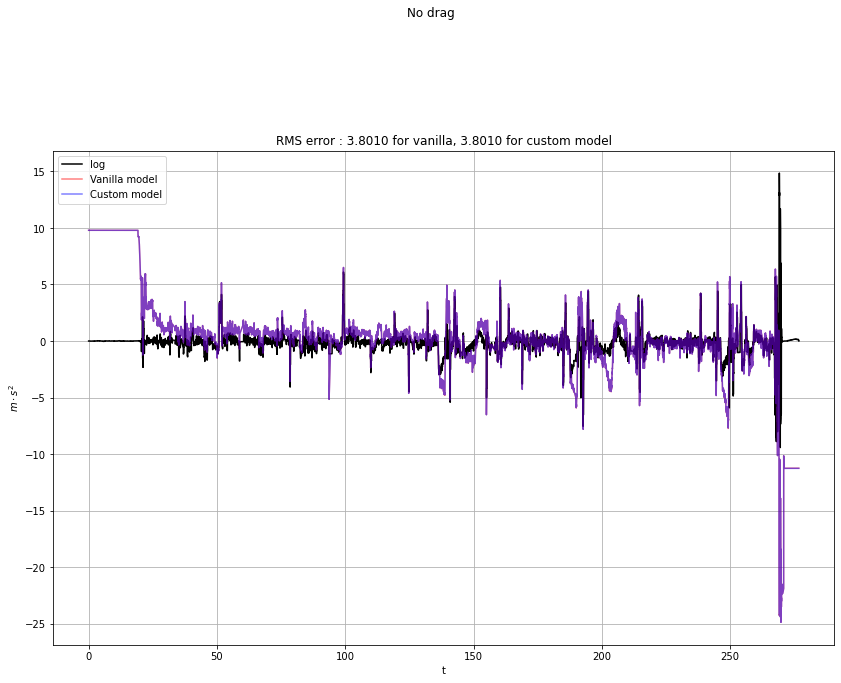

In [5]:
# %%% Comparison

f=plt.figure(figsize=(14,20))
f.suptitle(r"No drag")
ax=f.add_subplot(2,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label=r"log")
ax.plot(prep_data["t"],compute_acc_k(c1vanilla,vanilla=True),color="red",label=r"Vanilla model",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k(c1sol,c2=c2sol,model="MT"),color="blue",label=r"Custom model",alpha=0.5)
# ax.plot(prep_data["t"],compute_acc_k(c1sol,c2=c2sol,model="BET"),color="green",label=r"optimized, MT",alpha=0.5)
ax.set_ylabel(r'$m \cdot {s^{2}}$')
ax.set_xlabel(r't')
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s=r"RMS error : %.4f for vanilla, %.4f for custom model"%(round(np.sqrt(sol_vanilla['fun']),3),round(np.sqrt(sol_custom['fun']),4))
print(s)
ax.set_title(s)

print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k(c1sol,c2=c2sol,model="MT")-compute_acc_k(c1sol,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))

In [6]:

# %%   ####### Identify Thrust(with dk)


def compute_single_motor_thrust_MT_wdrag(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T


def compute_single_motor_thrust_BET_wdrag(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T

def compute_acc_k_wdrag(c1,dk,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(n_propellers)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) for i in range(n_propellers)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma-rho0*AN*dk*np.abs(vak)*vak/mass
    
    return acc_k

from scipy.optimize import minimize

import matplotlib.pyplot as plt


def cost_vanilla_wdrag(X):
    c1,dk=X
    Y=compute_acc_k_wdrag(c1,dk,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: VANILLA , dk: %f ,cost :%f"%(c1,dk,c))
    return c

X0_vanilla=np.array([6e-6,0])

sol_vanilla_drag=minimize(cost_vanilla_wdrag,X0_vanilla,method="SLSQP")
c1vanilla,dkvanilla=sol_vanilla_drag['x']


def cost_wdrag(X):
    c1,c2,dk=X
    Y=compute_acc_k_wdrag(c1,dk,c2=c2)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f ,c2: %f, dk: %f , cost :%f"%(c1,c2,dk,c))
    return c


X0=np.zeros(3)
sol_custom_drag=minimize(cost_wdrag,X0,method="SLSQP")

c1sol,c2sol,dksol=sol_custom_drag['x']



c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :97.902152
c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :97.901914
c1 :0.000006 ,c2: VANILLA , dk: 0.000000 ,cost :97.902152
c1 :15986.780809 ,c2: VANILLA , dk: -2.880047 ,cost :195674860123777.593750
c1 :1598.678086 ,c2: VANILLA , dk: -0.288005 ,cost :1956725599373.037109
c1 :159.867814 ,c2: VANILLA , dk: -0.028800 ,cost :19564955894.484344
c1 :15.986787 ,c2: VANILLA , dk: -0.002880 ,cost :195419636.251073
c1 :1.598684 ,c2: VANILLA , dk: -0.000288 ,cost :1931291.323952
c1 :0.159874 ,c2: VANILLA , dk: -0.000029 ,cost :17109.640201
c1 :0.015993 ,c2: VANILLA , dk: -0.000003 ,cost :37.999916
c1 :0.015993 ,c2: VANILLA , dk: -0.000003 ,cost :38.000043
c1 :0.015993 ,c2: VANILLA , dk: -0.000003 ,cost :37.999916
c1 :0.010636 ,c2: VANILLA , dk: 0.819347 ,cost :14.073066
c1 :0.010636 ,c2: VANILLA , dk: 0.819347 ,cost :14.073066
c1 :0.010636 ,c2: VANILLA , dk: 0.819347 ,cost :14.073066
c1 :0.010657 ,c2: VANILLA , dk: 0.914951 ,cost :14.067995
c1 :0

In [7]:

# %%% Comparison

f.suptitle("Thrust no drag / With drag")
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1vanilla,dkvanilla,vanilla=True),color="red",label="pred",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT"),color="blue",label="optimized, MT",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"),color="green",label="optimized, MT",alpha=0.5)
ax.legend()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla, %f for custom model"%(sol_vanilla_drag['fun'],sol_custom_drag['fun'])
ax.set_title(s)
print(s)


print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT")-compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))

# %%% Comparison
f.suptitle("Vanilla / Augmented with drag")
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1vanilla,dkvanilla,vanilla=True),color="darkred",label="pred",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="MT"),color="darkblue",label="optimized, MT",alpha=0.5)
ax.plot(prep_data["t"],compute_acc_k_wdrag(c1sol,dksol,c2=c2sol,model="BET"),color="darkgreen",label="optimized, MT",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
print("%f for vanilla, %f for custom model"%(sol_vanilla_drag['fun'],sol_custom_drag['fun']))


print('\n\nCoherence with ct2=ct1*b1-2/b1 formula ?\n')
print('with the formula : ')
print("ct2=%f"%(c1sol*b10-2/b10))
print("with the identification : ")
print("ct2=%f"%(c2sol))


print('\n\nCoherence with TMT=TBET ?\n')
yrms=np.sqrt(np.mean((compute_acc_k_wdrag(c1sol,dkvanilla,c2=c2sol,model="MT")-compute_acc_k_wdrag(c1sol,dkvanilla,c2=c2sol,model="BET"))**2))
print("output difference rms : %s m/s"%(yrms))


Performances: 
RMS error on acc pred is : 
14.067928 for vanilla, 13.714982 for custom model


Coherence with ct2=ct1*b1-2/b1 formula ?

with the formula : 
ct2=-0.061132
with the identification : 
ct2=-0.072539


Coherence with TMT=TBET ?

output difference rms : 1.3932853848813871e-15 m/s

Performances: 
RMS error on acc pred is : 
14.067928 for vanilla, 13.714982 for custom model


Coherence with ct2=ct1*b1-2/b1 formula ?

with the formula : 
ct2=-0.061132
with the identification : 
ct2=-0.072539


Coherence with TMT=TBET ?

output difference rms : 1.393000174885774e-15 m/s


In [8]:

# %%%   ####### Identify wirhout drag

def compute_ai_nod(di,df=prep_data):
    
    vai=df["speed_body[0]"]
    Fa=-rho0*AN*di*np.abs(vai)*vai
    gamma=df["gamma[0]"]

    return gamma

def cost_ai_nodrag(X):
    di=X
    
    Y=compute_ai_nod(di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("di :%f , cost :%f"%(di,c))

    return c
    
X0_di_nodrag=np.array([0])

sol_ai_nod=minimize(cost_ai_nodrag,X0_di_nodrag,method="SLSQP")
di_nod_=sol_ai_nod['x']
print("\n \n")


di :0.000000 , cost :0.355836
di :0.000000 , cost :0.355836

 



(<matplotlib.legend.Legend at 0x7fdc494904f0>,
 None,
 Text(0.5, 0, 't'),
 Text(0, 0.5, '$m \\cdot {s^{2}}$'))

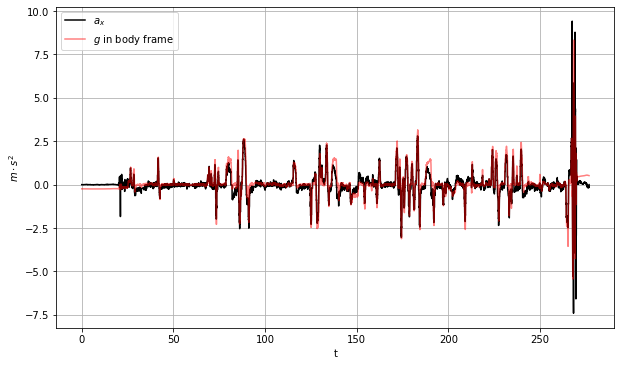

In [9]:
f=plt.figure(figsize=(10,13))
ax=f.add_subplot(2,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label=r"$a_x$")
ax.plot(prep_data["t"],compute_ai_nod(0),color="red",label=r"$g$ in body frame",alpha=0.5)
ax.legend(),ax.grid(),ax.set_xlabel('t'),ax.set_ylabel(r'$m \cdot {s^{2}}$')


In [10]:

# %%%   ####### Identify pure drag

def compute_ai_od(di,df=prep_data):
    
    vak=df["speed_body[0]"]
    Fa=-rho0*AN*di*np.abs(vak)*vak
    gamma=df["gamma[0]"]

    return Fa/mass+gamma

def cost_ai_onlydrag(X):
    di=X
    
    Y=compute_ai_od(di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("di :%f , cost :%f"%(di,c))

    return c
    
X0_di_onlydrag=np.array([0])

sol_ai_od=minimize(cost_ai_onlydrag,X0_di_onlydrag,method="SLSQP")
di_only_=sol_ai_od['x']
print("\n \n")


di :0.000000 , cost :0.355836
di :0.000000 , cost :0.355836
di :0.082910 , cost :0.349229
di :0.082910 , cost :0.349229
di :0.465188 , cost :0.325690
di :0.465188 , cost :0.325690
di :1.065001 , cost :0.311686
di :1.065001 , cost :0.311686

 



In [11]:

# %%%   ####### Identify H-force nodrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_ai_H_only(ch1,ch2,df=prep_data):

    vai=df["speed_body[0]"]
    vak=df["speed_body[2]"]

    gamma=df["gamma[0]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(n_propellers)])
    H_vect=-vai*H
    
    return H_vect/mass+gamma

def cost_ai_h_only(X):
    ch1,ch2=X

    Y=compute_ai_H_only(ch1,ch2)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_ai_onlyh=np.array([0,0])

sol_ai_oh=minimize(cost_ai_h_only,X0_ai_onlyh,method="SLSQP")
ch1_ai_only_,ch2_ai_only_=sol_ai_oh['x']
print("\n \n")

ch1 :0.000000 , ch2 :0.000000 , cost :0.355836
ch1 :0.000000 , ch2 :0.000000 , cost :0.355836
ch1 :0.000000 , ch2 :0.000000 , cost :0.355836
ch1 :3.885754 , ch2 :-0.324725 , cost :1264.974006
ch1 :0.388575 , ch2 :-0.032472 , cost :11.633609
ch1 :0.038858 , ch2 :-0.003247 , cost :0.331773
ch1 :0.038858 , ch2 :-0.003247 , cost :0.331773
ch1 :0.038858 , ch2 :-0.003247 , cost :0.331773
ch1 :0.021989 , ch2 :-0.015585 , cost :0.310494
ch1 :0.021989 , ch2 :-0.015585 , cost :0.310494
ch1 :0.021989 , ch2 :-0.015585 , cost :0.310494
ch1 :0.020875 , ch2 :-0.028704 , cost :0.310327
ch1 :0.020875 , ch2 :-0.028704 , cost :0.310327
ch1 :0.020875 , ch2 :-0.028704 , cost :0.310327
ch1 :0.015814 , ch2 :-0.092060 , cost :0.309631
ch1 :0.015814 , ch2 :-0.092060 , cost :0.309631
ch1 :0.015814 , ch2 :-0.092060 , cost :0.309631
ch1 :-0.000183 , ch2 :-0.292614 , cost :0.308680
ch1 :-0.000182 , ch2 :-0.292614 , cost :0.308680
ch1 :-0.000183 , ch2 :-0.292614 , cost :0.308680

 



In [12]:

# %%%   ####### Identify H-force wdrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_ai_H_wdrag(ch1,ch2,di,df=prep_data):
    
    vai=df["speed_body[0]"]
    vak=df["speed_body[2]"]

    gamma=df["gamma[0]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(n_propellers)])
    H_vect=-vai*H
    Fa=-rho0*AN*di*np.abs(vai)*vai

    return H_vect/mass+gamma+Fa/mass

def cost_ai_h_wdrag(X):
    ch1,ch2,di=X

    Y=compute_ai_H_wdrag(ch1,ch2,di)
    c=np.mean((Y-prep_data['acc_body_grad[0]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , di :%f , cost :%f"%(ch1,ch2,di,c))

    return c

X0_ai_hwd=np.array([0,0,0])

sol_ai_hwd=minimize(cost_ai_h_wdrag,X0_ai_hwd,method="SLSQP")
ch1_ai_wd_,ch2_ai_wd_,di_wd_=sol_ai_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.355836
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.355836
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.355836
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , cost :0.355836
ch1 :3.885754 , ch2 :-0.324725 , di :0.082910 , cost :1266.036641
ch1 :0.388575 , ch2 :-0.032472 , di :0.008291 , cost :11.643617
ch1 :0.038858 , ch2 :-0.003247 , di :0.000829 , cost :0.331811
ch1 :0.038858 , ch2 :-0.003247 , di :0.000829 , cost :0.331811
ch1 :0.038858 , ch2 :-0.003247 , di :0.000829 , cost :0.331811
ch1 :0.038858 , ch2 :-0.003247 , di :0.000829 , cost :0.331811
ch1 :0.021857 , ch2 :-0.015573 , di :0.006789 , cost :0.310452
ch1 :0.021857 , ch2 :-0.015573 , di :0.006789 , cost :0.310452
ch1 :0.021857 , ch2 :-0.015573 , di :0.006789 , cost :0.310452
ch1 :0.021857 , ch2 :-0.015573 , di :0.006789 , cost :0.310452
ch1 :0.020605 , ch2 :-0.028691 , di :0.013037 , cost :0.310247
ch1 :0.020605 , ch2 :-0.028691 , di :0.013037 , cost :0


Performances: 
RMS error on acc pred is : 
0.311686 for vanilla, 0.308680 for custom model, 0.307416 for full model


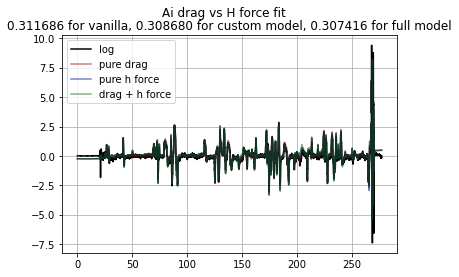

In [13]:

# %%%   ####### Comparison

f=plt.figure()
f.suptitle("Ai drag vs H force fit")
ax=f.add_subplot(1,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],compute_ai_H_only(ch1_ai_only_,ch2_ai_only_),color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],compute_ai_H_wdrag(ch1_ai_only_,ch2_ai_only_,di_wd_),color="darkgreen",label="drag + h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla, %f for custom model, %f for full model"%(sol_ai_od['fun'],sol_ai_oh['fun'],sol_ai_hwd['fun'])
ax.set_title(s)
print(s)



In [14]:

# %%%   ####### Identify wirhout drag

def compute_aj_nod(dj,df=prep_data):
    
    vaj=df["speed_body[1]"]
    Fa=-rho0*AN*dj*np.abs(vaj)*vaj
    gamma=df["gamma[1]"]

    return gamma

def cost_aj_nodrag(X):
    dj=X
    
    Y=compute_aj_nod(dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("di :%f , cost :%f"%(dj,c))

    return c
    
X0_dj_nodrag=np.array([0])

sol_aj_nod=minimize(cost_aj_nodrag,X0_dj_nodrag,method="SLSQP")
dj_nod_=sol_aj_nod['x']
print("\n \n")

di :0.000000 , cost :1.096641
di :0.000000 , cost :1.096641

 



In [15]:
# %% aj
# %%%   ####### Identify pure drag

def compute_aj_od(dj,df=prep_data):
    
    vak=df["speed_body[1]"]
    Fa=-rho0*AN*dj*np.abs(vak)*vak
    gamma=df["gamma[1]"]

    return Fa/mass+gamma

def cost_aj_onlydrag(X):
    dj=X
    
    Y=compute_aj_od(dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("dj :%f , cost :%f"%(dj,c))

    return c
    
X0_dj_onlydrag=np.array([1])

sol_aj_od=minimize(cost_aj_onlydrag,X0_dj_onlydrag,method="SLSQP")
dj_only_=sol_aj_od['x']
print("\n \n")

dj :1.000000 , cost :9.579990
dj :1.000000 , cost :9.579990
dj :-21.248730 , cost :6328.521169
dj :-1.224873 , cost :28.218858
dj :0.191859 , cost :0.589937
dj :0.191859 , cost :0.589937

 



In [16]:


# %%%   ####### Identify H-force nodrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_aj_H_only(ch1,ch2,df=prep_data):
    
    vak=df["speed_body[2]"]
    vaj=df["speed_body[1]"]

    gamma=df["gamma[1]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(n_propellers)])
    H_vect=-vaj*H
    
    return H_vect/mass+gamma

def cost_aj_h_only(X):
    ch1,ch2=X

    Y=compute_aj_H_only(ch1,ch2)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_aj_onlyh=np.array([0,0])

sol_aj_oh=minimize(cost_aj_h_only,X0_aj_onlyh,method="SLSQP")
ch1_aj_only_,ch2_aj_only_=sol_aj_oh['x']
print("\n \n")


ch1 :0.000000 , ch2 :0.000000 , cost :1.096641
ch1 :0.000000 , ch2 :0.000000 , cost :1.096640
ch1 :0.000000 , ch2 :0.000000 , cost :1.096641
ch1 :55.655644 , ch2 :-5.058005 , cost :4285365.063333
ch1 :5.565564 , ch2 :-0.505800 , cost :42573.654135
ch1 :0.556556 , ch2 :-0.050580 , cost :398.713998
ch1 :0.055656 , ch2 :-0.005058 , cost :2.261993
ch1 :0.020266 , ch2 :-0.001842 , cost :0.528027
ch1 :0.020266 , ch2 :-0.001842 , cost :0.528027
ch1 :0.020266 , ch2 :-0.001842 , cost :0.528027
ch1 :0.005771 , ch2 :-0.166754 , cost :0.516148
ch1 :0.005771 , ch2 :-0.166754 , cost :0.516148
ch1 :0.005771 , ch2 :-0.166754 , cost :0.516148
ch1 :0.007473 , ch2 :-0.147387 , cost :0.515933
ch1 :0.007473 , ch2 :-0.147387 , cost :0.515933
ch1 :0.007473 , ch2 :-0.147387 , cost :0.515933

 



In [17]:

# %%%   ####### Identify H-force wdrag


def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H

def compute_aj_H_wdrag(ch1,ch2,dj,df=prep_data):
    
    vak=df["speed_body[2]"]
    vaj=df["speed_body[1]"]

    gamma=df["gamma[1]"]
    
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(n_propellers)])
    H_vect=-vaj*H
    Fa=-rho0*AN*dj*np.abs(vaj)*vaj

    return H_vect/mass+gamma+Fa/mass

def cost_aj_h_wdrag(X):
    ch1,ch2,dj=X

    Y=compute_aj_H_wdrag(ch1,ch2,dj)
    c=np.mean((Y-prep_data['acc_body_grad[1]'])**2,axis=0)
    print("ch1 :%f , ch2 :%f , dj :%f , cost :%f"%(ch1,ch2,dj,c))

    return c

X0_aj_hwd=np.array([0,0,0])

sol_aj_hwd=minimize(cost_aj_h_wdrag,X0_aj_hwd,method="SLSQP")
ch1_aj_wd_,ch2_aj_wd_,dj_wd_=sol_aj_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :1.096641
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :1.096640
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :1.096641
ch1 :0.000000 , ch2 :0.000000 , dj :0.000000 , cost :1.096641
ch1 :55.655644 , ch2 :-5.058005 , dj :5.282034 , cost :4360786.212263
ch1 :5.565564 , ch2 :-0.505800 , dj :0.528203 , cost :43325.354634
ch1 :0.556556 , ch2 :-0.050580 , dj :0.052820 , cost :405.979904
ch1 :0.055656 , ch2 :-0.005058 , dj :0.005282 , cost :2.309542
ch1 :0.020093 , ch2 :-0.001826 , dj :0.001907 , cost :0.527830
ch1 :0.020093 , ch2 :-0.001826 , dj :0.001907 , cost :0.527830
ch1 :0.020093 , ch2 :-0.001826 , dj :0.001907 , cost :0.527830
ch1 :0.020093 , ch2 :-0.001826 , dj :0.001907 , cost :0.527830
ch1 :-0.003492 , ch2 :-0.165460 , dj :0.100752 , cost :0.529714
ch1 :0.008871 , ch2 :-0.079689 , dj :0.048941 , cost :0.519002
ch1 :0.008871 , ch2 :-0.079689 , dj :0.048941 , cost :0.519002
ch1 :0.008871 , ch2 :-0.079689 , dj :0.048941


Performances: 
RMS error on acc pred is : 
0.589937 for vanilla 
 0.515933 for custom model 
 0.515297 for full model


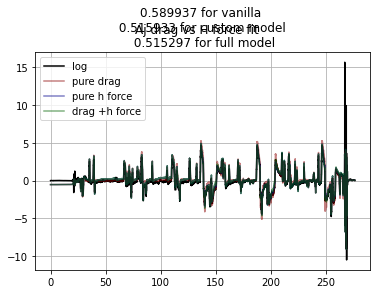

In [18]:
# %%%   ####### Comparison

f=plt.figure()
f.suptitle("Aj drag vs H force fit")
ax=f.add_subplot(1,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],compute_aj_H_only(ch1_aj_only_,ch2_aj_only_),color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],compute_aj_H_wdrag(ch1_aj_only_,ch2_aj_only_,dj_wd_),color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aj_od['fun'],sol_aj_oh['fun'],sol_aj_hwd["fun"])
ax.set_title(s)
print(s)
# %% aij

In [19]:


# %%% H nodrag

def compute_aij_H_wdrag(ch1,ch2,di=0,dj=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]

    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(n_propellers)])
    H_vect=np.c_[-vai*H,-vaj*H]
    
    Fa=-rho0*AN*np.c_[di*np.abs(vai)*vai,dj*np.abs(vaj)*vaj]

    return H_vect/mass+np.c_[gammai,gammaj]+Fa/mass

def cost_aij_h_nodrag(X):
    ch1,ch2=X
    Y=compute_aij_H_wdrag(ch1,ch2,di=0,dj=0)
    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj
    print("ch1 :%f , ch2 :%f , cost :%f"%(ch1,ch2,c))

    return c

X0_aij_nodrag=np.array([0,0])

sol_aij_nodrag=minimize(cost_aij_h_nodrag,X0_aij_nodrag,method="SLSQP")
ch1_aij_nodrag_,ch2_aij_nodrag_=sol_aij_nodrag['x']



ch1 :0.000000 , ch2 :0.000000 , cost :1.452476
ch1 :0.000000 , ch2 :0.000000 , cost :1.452476
ch1 :0.000000 , ch2 :0.000000 , cost :1.452477
ch1 :59.541399 , ch2 :-5.382730 , cost :5205057.309627
ch1 :5.954140 , ch2 :-0.538273 , cost :51730.337262
ch1 :0.595414 , ch2 :-0.053827 , cost :486.573946
ch1 :0.059541 , ch2 :-0.005383 , cost :3.086953
ch1 :0.020429 , ch2 :-0.001847 , cost :0.839332
ch1 :0.020429 , ch2 :-0.001847 , cost :0.839332
ch1 :0.020429 , ch2 :-0.001847 , cost :0.839332
ch1 :0.005118 , ch2 :-0.176945 , cost :0.826816
ch1 :0.005118 , ch2 :-0.176945 , cost :0.826816
ch1 :0.005118 , ch2 :-0.176945 , cost :0.826816
ch1 :0.007559 , ch2 :-0.149024 , cost :0.826349
ch1 :0.007559 , ch2 :-0.149024 , cost :0.826349
ch1 :0.007559 , ch2 :-0.149024 , cost :0.826349


In [20]:


# %%% H wd


def cost_aij_h_wdrag(X):
    ch1,ch2,di,dj=X

    Y=compute_aij_H_wdrag(ch1,ch2,di,dj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj

    print("ch1 :%f , ch2 :%f , di :%f , dj : %f , cost :%f"%(ch1,ch2,di,dj,c))

    return c

X0_aij_hwd=np.array([0,0,0,0])

sol_aij_hwd=minimize(cost_aij_h_wdrag,X0_aij_hwd,method="SLSQP")
ch1_aij_wd_,ch2_aij_wd_,di_aij_wd_,dj_aij_wd_=sol_aij_hwd['x']

ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.452476
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.452476
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.452477
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.452476
ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , cost :1.452476
ch1 :59.541399 , ch2 :-5.382730 , di :0.082910 , dj : 5.282034 , cost :5285732.338223
ch1 :5.954140 , ch2 :-0.538273 , di :0.008291 , dj : 0.528203 , cost :52534.575939
ch1 :0.595414 , ch2 :-0.053827 , di :0.000829 , dj : 0.052820 , cost :494.365172
ch1 :0.059541 , ch2 :-0.005383 , di :0.000083 , dj : 0.005282 , cost :3.139749
ch1 :0.020274 , ch2 :-0.001833 , di :0.000028 , dj : 0.001799 , cost :0.839222
ch1 :0.020274 , ch2 :-0.001833 , di :0.000028 , dj : 0.001799 , cost :0.839222
ch1 :0.020274 , ch2 :-0.001833 , di :0.000028 , dj : 0.001799 , cost :0.839222
ch1 :0.020274 , ch2 :-0.001833 , di :0.00002


Performances: 
RMS error on acc pred is : 
0.311686 for vanilla 
  0.310342 for custom model 
 0.307921 for full model

Performances: 
RMS error on acc pred is : 
0.589937 for vanilla 
 1.883291 for custom model 
 1.891599 for full model


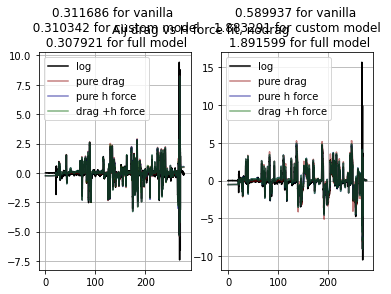

In [21]:



# %%% Comparison ai
aind,ajnd=compute_aij_H_wdrag(ch1_aij_nodrag_,ch2_aij_nodrag_).T
aid,ajd=compute_aij_H_wdrag(ch1_aij_wd_,ch2_aij_wd_,di_aij_wd_,dj_aij_wd_).T

f=plt.figure()
f.suptitle("Aij drag vs H force fit, nodrag")
ax=f.add_subplot(1,2,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],aind,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],aid,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_nd=np.mean((aind-prep_data['acc_body_grad[0]'])**2,axis=0)
c_i_d=np.mean((aid-prep_data['acc_body_grad[0]'])**2,axis=0)                            
s="%f for vanilla \n  %f for custom model \n %f for full model"%(sol_ai_od['fun'],c_i_nd,c_i_d)
ax.set_title(s)
print(s)

# %%% Comparison aj

ax=f.add_subplot(1,2,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],ajnd,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],ajd,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_j_nd=np.mean((ajnd-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_d=np.mean((ajd-prep_data['acc_body_grad[0]'])**2,axis=0)  
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aj_od['fun'],c_j_nd,c_j_d)
ax.set_title(s)
print(s)



In [22]:


# %% aij (di_eq_dj)
 
# %%% H nodrag

def compute_aij_H_wdrag(ch1,ch2,di=0,dj=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]

    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(n_propellers)])
    H_vect=np.c_[-vai*H,-vaj*H]
    
    Fa=-rho0*AN*np.c_[di*np.abs(vai)*vai,dj*np.abs(vaj)*vaj]

    return H_vect/mass+np.c_[gammai,gammaj]+Fa/mass


# %%% H wd


def cost_aij_h_wdrag_di_eq_dj_(X):
    ch1,ch2,di=X

    Y=compute_aij_H_wdrag(ch1,ch2,di,di)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)

    c=ci+cj

    print("ch1 :%f , ch2 :%f , dij :%f  , cost :%f"%(ch1,ch2,di,c))

    return c

X0_aij_hwd_di_eq_dj_=np.array([0,0,0])

sol_aij_hwd_di_eq_dj_=minimize(cost_aij_h_wdrag_di_eq_dj_,X0_aij_hwd_di_eq_dj_,method="SLSQP")
ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_=sol_aij_hwd_di_eq_dj_['x']


ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :1.452476
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :1.452476
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :1.452477
ch1 :0.000000 , ch2 :0.000000 , dij :0.000000  , cost :1.452476
ch1 :59.541399 , ch2 :-5.382730 , dij :5.364945  , cost :5288049.573079
ch1 :5.954140 , ch2 :-0.538273 , dij :0.536494  , cost :52557.669459
ch1 :0.595414 , ch2 :-0.053827 , dij :0.053649  , cost :494.588224
ch1 :0.059541 , ch2 :-0.005383 , dij :0.005365  , cost :3.141192
ch1 :0.020270 , ch2 :-0.001832 , dij :0.001826  , cost :0.839192
ch1 :0.020270 , ch2 :-0.001832 , dij :0.001826  , cost :0.839192
ch1 :0.020270 , ch2 :-0.001832 , dij :0.001826  , cost :0.839192
ch1 :0.020270 , ch2 :-0.001832 , dij :0.001826  , cost :0.839192
ch1 :-0.001306 , ch2 :-0.175754 , dij :0.073462  , cost :0.838318
ch1 :0.009212 , ch2 :-0.090968 , dij :0.038540  , cost :0.830007
ch1 :0.009212 , ch2 :-0.090968 , dij :0.038540  , cost :0.830007
ch1 :0.009212 ,


Performances: 
RMS error on acc pred is : 
0.826251 for vanilla 
 0.310727 for custom model 
 0.310600 for full model

Performances: 
RMS error on acc pred is : 
0.826251 for vanilla 
 1.882636 for custom model 
 1.887714 for full model


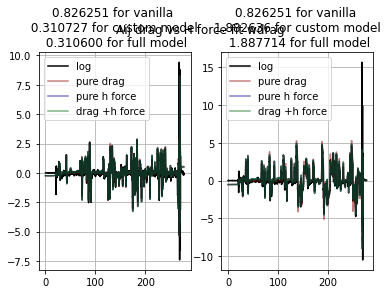

In [23]:


# %%% Comparison ai
aind,ajnd=compute_aij_H_wdrag(ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_).T
aid,ajd=compute_aij_H_wdrag(ch1_aij_wd_di_eq_dj_,ch2_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_,dij_aij_wd_di_eq_dj_).T

f=plt.figure()
f.suptitle("Aij drag vs H force fit wdrag")
ax=f.add_subplot(1,2,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],compute_ai_od(di_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],aind,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],aid,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_nd=np.mean((aind-prep_data['acc_body_grad[0]'])**2,axis=0)
c_i_d=np.mean((aid-prep_data['acc_body_grad[0]'])**2,axis=0)                            
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aij_hwd_di_eq_dj_['fun'],c_i_nd,c_i_d)
ax.set_title(s)
print(s)

# %%% Comparison aj

ax=f.add_subplot(1,2,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],compute_aj_od(dj_only_),color="darkred",label="pure drag",alpha=0.5)
ax.plot(prep_data["t"],ajnd,color="darkblue",label="pure h force",alpha=0.5)
ax.plot(prep_data["t"],ajd,color="darkgreen",label="drag +h force",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_j_nd=np.mean((ajnd-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_d=np.mean((ajd-prep_data['acc_body_grad[0]'])**2,axis=0)  
s="%f for vanilla \n %f for custom model \n %f for full model"%(sol_aij_hwd_di_eq_dj_['fun'],c_j_nd,c_j_d)
ax.set_title(s)
print(s)

In [24]:


# %% Global 

def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H


def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) 
                   for i in range(n_propellers)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) 
                   for i in range(n_propellers)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k


def compute_acc_global(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) 
           for i in range(n_propellers)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) 
           for i in range(n_propellers)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*AN*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect/mass+np.c_[gammai,gammaj,gammak]+Fa/mass


def cost_global_(X):
    ct1,ct2,ch1,ch2,di,dj,dk=X

    Y=compute_acc_global(ct1,ct2,ch1,ch2,di,dj,dk)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , cost :%f"%(ct1,ct2,ch1,ch2,di,dj,dk,c))

    return c

X0_global_=np.zeros(7)

sol_global_=minimize(cost_global_,X0_global_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global=sol_global_['x']


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452826
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827



Performances: 
RMS error on acc pred is : 
0.310076 for i 
 0.515692 for j 
 13.703249 for k


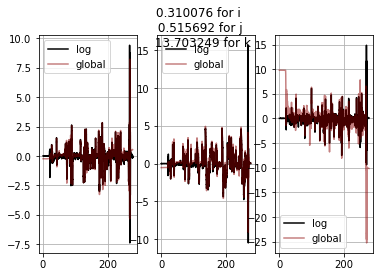

In [25]:




# %%% Comparison a i j k
Y=compute_acc_global(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global)

f=plt.figure()
ax=f.add_subplot(1,3,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(1,3,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(1,3,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  
c_k_=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  


s="%f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)



In [26]:


# %% Global 

def compute_eta(vak,omega,c1=c1sol,c2=c2sol):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)
    return eta

def compute_H(vak,omega,ch1,ch2):
    eta=compute_eta(vak,omega)
    H=rho0*Area*(ch1*r0*omega-ch2*(eta-vak))
    return H


def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=c1*omega**2
    return T

def compute_acc_k(c1,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) 
                   for i in range(n_propellers)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,df['omega_c[%i]'%(i+1)],c2,vanilla_test=vanilla) 
                   for i in range(n_propellers)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma
    
    return acc_k


def compute_acc_global(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data,vwi=0,vwj=0):
    
    vai=df["speed_body[0]"]
    vaj=df["speed_body[1]"]
    vak=df["speed_body[2]"]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(n_propellers)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(n_propellers)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*AN*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect+np.c_[gammai,gammaj,gammak]+Fa


def cost_global_dij_(X):
    ct1,ct2,ch1,ch2,dij,dk=X

    Y=compute_acc_global(ct1,ct2,ch1,ch2,dij,dij,dk)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , cost :%f"%(ct1,ct2,ch1,ch2,dij,dij,dk,c))

    return c

X0_global_dij_=np.zeros(6)

sol_global_dij_=minimize(cost_global_dij_,X0_global_dij_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dk_global=sol_global_dij_['x']
dj_global=di_global


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452826
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , cost :0.452827
ct1 :72.530945, ct2 :-0.478779 , ch1 :0.511911 , ch2 :-0.045916 , di :0.048838 , dj : 0.048838 , dk : -0.047649 , cost :19767


Performances: 
RMS error on acc pred is : 
IJ EQUAL 
 0.309705 for i 
 0.518501 for j 
 13.703270 for k


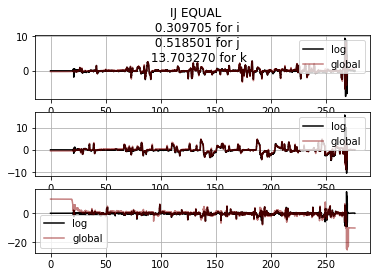

In [27]:

# %%% Comparison a i j k ij equal
Y=compute_acc_global(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global)

f=plt.figure()
ax=f.add_subplot(3,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global",alpha=0.5)
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
c_i_=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0)
c_j_=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  
c_k_=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  


s="IJ EQUAL \n %f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)




In [28]:


# %% WITH WIND 



def compute_acc_global_wind(ct1,ct2,ch1,ch2,di=0,dj=0,dk=0,df=prep_data,vwi=0,vwj=0):

    q0,q1,q2,q3=(prep_data['q[0]'],prep_data['q[1]'],
                 prep_data['q[2]'],prep_data['q[3]'])
    
    "precomputing transposition"
#     R_transpose=np.array([tf3d.quaternions.quat2mat([i,j,k,l]).T for i,j,k,l in zip(q0,q1,q2,q3)])
    
#     vw_earth=np.array([vwi,vwj,0])
    vw_body=vwi*np.array([i for i in df['vwx_body_dir'].values])+vwj*np.array([i for i in df['vwy_body_dir'].values])
    
    
    vai=df["speed_body[0]"]-vw_body[:,0]
    vaj=df["speed_body[1]"]-vw_body[:,1]
    vak=df["speed_body[2]"]-vw_body[:,2]
    
    gammai=df["gamma[0]"]
    gammaj=df["gamma[1]"]
    gammak=df["gamma[2]"]
    
    T=sum([compute_single_motor_thrust_MT(ct1,vak,df['omega_c[%i]'%(i+1)],ct2) for i in range(n_propellers)])
    H=sum([compute_H(vak,df['omega_c[%i]'%(i+1)],ch1,ch2) for i in range(n_propellers)])
    
    H_vect=np.c_[-vai*H,-vaj*H,np.zeros(H.shape)]
    T_vect=np.c_[np.zeros(T.shape),np.zeros(T.shape),T]
    absva=np.sqrt(vai**2+vaj**2+vak**2)
    Fa=-rho0*AN*np.c_[di*absva*vai,dj*absva*vaj,dk*absva*vak]

    return -T_vect/mass+H_vect/mass+np.c_[gammai,gammaj,gammak]+Fa/mass


def cost_global_dij_wind_(X):
    ct1,ct2,ch1,ch2,dij,dk,vwi,vwj=X

    Y=compute_acc_global_wind(ct1,ct2,ch1,ch2,dij,dij,dk,vwi=vwi,vwj=vwj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print("ct1 :%f, ct2 :%f , ch1 :%f , ch2 :%f , di :%f , dj : %f , dk : %f , vwi : %f ,vwj : %f cost :%f"%(ct1,ct2,ch1,ch2,dij,dij,dk,vwi,vwj,c))

    return c


X0_global_dij_wind_=np.zeros(8)

sol_global_dij_wind_=minimize(cost_global_dij_wind_,X0_global_dij_wind_,method="SLSQP")
ct1_global,ct2_global,ch1_global,ch2_global,di_global,dk_global,vwi_global_,vwj_global_=sol_global_dij_wind_['x']
dj_global=di_global


ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :0.452826
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , di :0.000000 , dj : 0.000000 , dk : 0.000000 , vwi : 0.000000 ,vwj : 0.000000 cost :0.452827
ct1 :0.000000, ct2 :0.000000 , ch1 :0.000000 , ch2 :0.000000 , d


Performances: 
RMS error on acc pred is : 
WIND 
 0.187862 for i 
 0.295816 for j 
 1.766851 for k


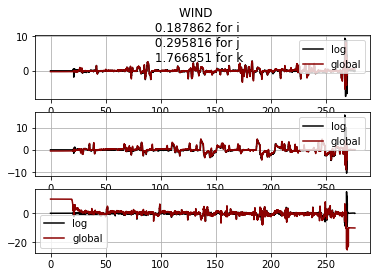

In [29]:
# % Comparison

Y=compute_acc_global_wind(ct1_global,ct2_global,ch1_global,ch2_global,di_global,dj_global,dk_global,vwi=vwi_global_,vwj=vwj_global_)



f=plt.figure()
ax=f.add_subplot(3,1,1)
ax.plot(prep_data["t"],prep_data['acc_body_grad[0]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,0],color="darkred",label="global")
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,2)
ax.plot(prep_data["t"],prep_data['acc_body_grad[1]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,1],color="darkred",label="global")
ax.legend(),ax.grid()

ax=f.add_subplot(3,1,3)
ax.plot(prep_data["t"],prep_data['acc_body_grad[2]'],color="black",label="log")
ax.plot(prep_data["t"],Y[:,2],color="darkred",label="global")
ax.legend(),ax.grid()

print("\nPerformances: ")
print("RMS error on acc pred is : ")
# c_i_=np.sqrt(np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2,axis=0))
# c_j_=np.sqrt(np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2,axis=0)  )
# c_k_=np.sqrt(np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2,axis=0)  )

c_i_=np.mean(np.abs(Y[:,0]-prep_data['acc_body_grad[0]']),axis=0)
c_j_=np.mean(np.abs(Y[:,1]-prep_data['acc_body_grad[1]']),axis=0)  
c_k_=np.mean(np.abs(Y[:,2]-prep_data['acc_body_grad[2]']),axis=0)  
s="WIND \n %f for i \n %f for j \n %f for k"%(c_i_,c_j_,c_k_)
f.suptitle(s)
print(s)



In [30]:





# %% Synthesis


bilan=pd.DataFrame(data=None,
                    columns=['ct1','ct2',
                            'ch1','ch2',
                            'di','dj','dk','vwi','vwj',
                            'cost'],
                    index=['vanilla','custom',
                          'vanilla_dk','custom_with_dk',
                          'ai_nodrag','ai_drag','ai_h','ai_drag_and_h',
                          'aj_nodrag','aj_drag','aj_h','aj_drag_and_h',
                          'aij_h','aij_h_and_drag',
                          'aij_h_drag_equal_coeffs',
                          "global","global_equal_coeffs","global_wind"])




bilan.loc["vanilla"]['ct1','cost']=np.r_[sol_vanilla['x'],np.sqrt(sol_vanilla['fun'])]
bilan.loc["custom"]['ct1','ct2','cost']=np.r_[sol_custom['x'],np.sqrt(sol_custom['fun'])]

bilan.loc["vanilla_dk"]['ct1','dk','cost']=np.r_[sol_vanilla_drag['x'],np.sqrt(sol_vanilla_drag['fun'])]
bilan.loc["custom_with_dk"]['ct1','ct2','dk','cost']=np.r_[sol_custom_drag['x'],np.sqrt(sol_custom_drag['fun'])]


bilan.loc['ai_nodrag']['cost']=np.sqrt(sol_ai_nod['fun'])
bilan.loc['ai_drag']['di','cost']=np.r_[sol_ai_od['x'],np.sqrt(sol_ai_od['fun'])]
bilan.loc['ai_h']['ch1','ch2','cost']=np.r_[sol_ai_oh['x'],np.sqrt(sol_ai_oh['fun'])]
bilan.loc['ai_drag_and_h']['ch1','ch2','di','cost']=np.r_[sol_ai_hwd['x'],np.sqrt(sol_ai_hwd['fun'])]

bilan.loc['aj_nodrag']['cost']=np.sqrt(sol_aj_nod['fun'])
bilan.loc['aj_drag']['dj','cost']=np.r_[sol_aj_od['x'],np.sqrt(sol_aj_od['fun'])]
bilan.loc['aj_h']['ch1','ch2','cost']=np.r_[sol_aj_oh['x'],np.sqrt(sol_aj_oh['fun'])]
bilan.loc['aj_drag_and_h']['ch1','ch2','dj','cost']=np.r_[sol_aj_hwd['x'],np.sqrt(sol_aj_hwd['fun'])]


bilan.loc['aij_h']['ch1','ch2','cost']=np.r_[sol_aij_nodrag['x'],np.sqrt(sol_aij_nodrag['fun'])]
bilan.loc['aij_h_and_drag']['ch1','ch2','di','dj','cost']=np.r_[sol_aij_hwd['x'],np.sqrt(sol_aij_hwd['fun'])]

bilan.loc['aij_h_drag_equal_coeffs']['ch1','ch2','di','cost']=np.r_[sol_aij_hwd_di_eq_dj_['x'],np.sqrt(sol_aij_hwd_di_eq_dj_['fun'])]
bilan.loc['aij_h_drag_equal_coeffs']['dj']=bilan.loc['aij_h_drag_equal_coeffs']['di']

bilan.loc['global']['ct1','ct2',
                    'ch1','ch2',
                    'di','dj','dk',
                    'cost']=np.r_[sol_global_['x'],np.sqrt(sol_global_['fun'])]

bilan.loc['global_equal_coeffs']['ct1','ct2',
                    'ch1','ch2',
                    'di','dk',
                    'cost']=np.r_[sol_global_dij_['x'],np.sqrt(sol_global_dij_['fun'])]

bilan.loc['global_equal_coeffs']["dj"]=bilan.loc['global_equal_coeffs']["di"]

bilan.loc['global_wind']['ct1','ct2',
                    'ch1','ch2',
                    'di','dk','vwi','vwj',
                    'cost']=np.r_[sol_global_dij_wind_['x'],np.sqrt(sol_global_dij_wind_['fun'])]
bilan.loc['global_wind']["dj"]=bilan.loc['global_wind']["di"]




print(bilan)



bilan.to_csv('./bilan_id.csv')

                              ct1       ct2       ch1       ch2        di  \
vanilla                  0.010446       NaN       NaN       NaN       NaN   
custom                   0.010495  0.000649       NaN       NaN       NaN   
vanilla_dk               0.010661       NaN       NaN       NaN       NaN   
custom_with_dk           0.005358 -0.072539       NaN       NaN       NaN   
ai_nodrag                     NaN       NaN       NaN       NaN       NaN   
ai_drag                       NaN       NaN       NaN       NaN  1.065001   
ai_h                          NaN       NaN -0.000183 -0.292614       NaN   
ai_drag_and_h                 NaN       NaN -0.007282 -0.271784  0.444802   
aj_nodrag                     NaN       NaN       NaN       NaN       NaN   
aj_drag                       NaN       NaN       NaN       NaN       NaN   
aj_h                          NaN       NaN  0.007473 -0.147387       NaN   
aj_drag_and_h                 NaN       NaN  0.006162 -0.143277       NaN   

In [31]:
# %% ID WIND ONLY



def cost_global_dij_wind_only(X):
    
    ct1,ct2,dk = bilan.loc["custom_with_dk"][['ct1','ct2','dk']].values
    ch1,ch2,di = bilan.loc['aij_h_drag_equal_coeffs'][['ch1','ch2','di']].values
    dij = di 
    
    vwi,vwj=X

    Y=compute_acc_global_wind(ct1,ct2,ch1,ch2,dij,dij,dk,vwi=vwi,vwj=vwj)

    ci=np.mean((Y[:,0]-prep_data['acc_body_grad[0]'])**2/max(abs(prep_data['acc_body_grad[0]']))**2,axis=0)
    cj=np.mean((Y[:,1]-prep_data['acc_body_grad[1]'])**2/max(abs(prep_data['acc_body_grad[1]']))**2,axis=0)
    ck=np.mean((Y[:,2]-prep_data['acc_body_grad[2]'])**2/max(abs(prep_data['acc_body_grad[2]']))**2,axis=0)
    
    c=ci+cj+ck

    print(" vwi : %f ,vwj : %f cost :%f"%(vwi,vwj,c))

    return c


X0_global_dij_wind_only=np.zeros(2)

sol_global_dij_wind_only=minimize(cost_global_dij_wind_only,X0_global_dij_wind_only,method="SLSQP")
vwi_only_,vwj_only_= sol_global_dij_wind_only['x']


 vwi : 0.000000 ,vwj : 0.000000 cost :0.077653
 vwi : 0.000000 ,vwj : 0.000000 cost :0.077653
 vwi : 0.000000 ,vwj : 0.000000 cost :0.077653


In [32]:

# %%   ####### Identify kt 

def compute_single_motor_thrust_MT(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=2*rho0*Area*eta*(eta-vak)

    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T


def compute_single_motor_thrust_BET(c1,vak,omega,c2=0,vanilla_test=False):
    
    eta=vak/2-r0*omega*c2/4
    eta=eta+0.5*np.sqrt((vak+0.5*r0*omega*c2)**2+2*c1*r0**2*omega**2)

    T=rho0*Area*r0*omega*(c1*r0*omega-c2*(eta-vak))
    if vanilla_test:
        T=rho0*Area*r0**2*omega**2*c1
    return T

def compute_omegas(df,kt):
    # omegas is shape n timesteps x p actuators 
    omegas=np.array([prep_data['omega_c[%i]'%(i+1)] for i in range(n_propellers)]).T
    
    b, a = scipy.signal.butter(1, 1./(2*np.pi)*kt,analog= False,fs=1./2.0/df['dt'].mean())
    zi = scipy.signal.lfilter_zi(b, a)
    new_omegas, _ =scipy.signal.lfilter(b, a, omegas,axis=0,zi=zi*omegas[0].reshape((1,-1)))
    return new_omegas



def compute_acc_k_wdrag_kt(c1,dk,kt,c2=0,df=prep_data,vanilla=False,model="MT"):
    
    vak=df["speed_body[2]"]
    gamma=df["gamma[2]"]
    
    omegas=compute_omegas(df,kt)
    
    if model=="MT":
        T_sum=sum([compute_single_motor_thrust_MT(c1,vak,omegas[:,i],c2,vanilla_test=vanilla) 
                   for i in range(n_propellers)])
    elif model=="BET":
        T_sum=sum([compute_single_motor_thrust_BET(c1,vak,omegas[:,i],c2,vanilla_test=vanilla) 
                   for i in range(n_propellers)])
    else:
        return print("FIX MODEL")
    acc_k=-T_sum/mass+gamma-rho0*AN*dk*np.abs(vak)*vak/mass
    
    return acc_k


def cost_vanilla_kt(X):
    c1,dk,kt=X
    Y=compute_acc_k_wdrag_kt(c1,dk,kt,vanilla=True)
    c=np.mean((Y-prep_data['acc_body_grad[2]'])**2,axis=0)
    print("c1 :%f , dk :%f , kt :%f VANILLA ,cost :%f"%(c1,dk,kt,c))
    return c

X0_vanilla_kt=np.array([0,0,1.0])

sol_vanilla_kt=minimize(cost_vanilla_kt,X0_vanilla_kt,method="SLSQP")
c1vanillakt,dkvanillakt,ktvanillakt=sol_vanilla_kt['x']
print("\n \n")

print("Final RMS ", np.sqrt(sol_vanilla_kt['fun']))

c1 :0.000000 , dk :0.000000 , kt :1.000000 VANILLA ,cost :97.998101
c1 :0.000000 , dk :0.000000 , kt :1.000000 VANILLA ,cost :97.997866
c1 :0.000000 , dk :0.000000 , kt :1.000000 VANILLA ,cost :97.998101
c1 :0.000000 , dk :0.000000 , kt :1.000000 VANILLA ,cost :97.998101
c1 :15764.834696 , dk :-2.882236 , kt :1.000000 VANILLA ,cost :183516472122240.781250
c1 :1576.483470 , dk :-0.288224 , kt :1.000000 VANILLA ,cost :1835142353601.775146
c1 :157.648347 , dk :-0.028822 , kt :1.000000 VANILLA ,cost :18349186861.272648
c1 :15.764835 , dk :-0.002882 , kt :1.000000 VANILLA ,cost :183268288.454508
c1 :1.576483 , dk :-0.000288 , kt :1.000000 VANILLA ,cost :1810412.185031
c1 :0.157648 , dk :-0.000029 , kt :1.000000 VANILLA ,cost :15964.368207
c1 :0.015765 , dk :-0.000003 , kt :1.000000 VANILLA ,cost :32.984625
c1 :0.015765 , dk :-0.000003 , kt :1.000000 VANILLA ,cost :32.984737
c1 :0.015765 , dk :-0.000003 , kt :1.000000 VANILLA ,cost :32.984625
c1 :0.015765 , dk :-0.000003 , kt :1.000000 VANIL